# Data Challenge 9 — Feature Engineering & Feature Selection

**Format:** Instructor Guidance → You Do (Students) → We Share (Reflection)

**Goal:** Engineer better predictors (one-hot/dummies, interactions, polynomials), avoid unnecessary complexity, and compare a **Base** vs **Engineered** model on the **same train–test split** using **MAE/RMSE**. Interpret coefficients in units and explain business value.



> Dataset: **NYC Yellow Taxi — Dec 2023** (CSV). Keep code *simple*: light numeric coercion only for your chosen columns.

## Instructor Guidance

**Hint: Use the Lecture Deck, Canvas Reading, and Docs to help you with the code**

**Docs (quick links):**
- One-hot encoding (pandas): https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html  
- OneHotEncoder (sklearn): https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html  
- Train/Test Split: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html  
- MAE / MSE / RMSE: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html  
- OLS (statsmodels): https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html  
- OLS Results (coef/p/CIs/resid): https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html

### Pseudocode Plan (Feature Engineering + Selection)
1) **Load CSV** → preview columns/shape.  
2) **Pick Y and initial Xs (2–3 numeric)** → keep it simple and decision-time-available.  
3) **Engineer features:**
   - **One-hot** a categorical with a dropped baseline (e.g., `payment_type` or `weekday/weekend`).  
   - **Interaction**: choose a hypothesis-driven pair (e.g., `trip_distance × is_weekend`).  
   - **Polynomial**: add one squared term for a plausible curve (e.g., `trip_distance²`).  
4) **Build Base vs Engineered design matrices** (add intercept).  
5) **Single train–test split** (80/20, fixed `random_state`) shared by both models.  
6) **Fit on TRAIN**, **predict on TEST** for both models; compute **MAE/RMSE** (units of Y).  
7) **Interpretation**: write unit-based coefficient sentences; note baseline category for dummies.  
8) **Light selection**: if Engineered model doesn’t beat Base on TEST (or adds complexity w/o value), prefer Base.  
9) **Diagnostics (quick)**: residuals vs fitted (train); note any cones (heteroskedasticity).  
10) **Stakeholder one-liner**: which model, why (TEST metrics in units), and what the added features *mean*.
markdown


## You Do — Student Section
Work in pairs. Comment your choices briefly. Keep code simple—only coerce the columns you use.

### Step 0 — Setup & Imports

In [1]:
import pandas as pd, numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import scipy.stats as stats
from pathlib import Path

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')

### Step 1 — Load CSV & Preview
- Point to your **Dec 2023** taxi CSV.
- Print **shape** and **columns**.

**Hint: You may have to drop missing values and do a force coercion to make sure the variables stay numeric (other coding assignments may help)**

In [2]:
path = '/Users/Marcy_Student/Desktop/Marcy-Modules/marcy-git/DA2025_Lectures/Mod6/data/2023_Yellow_Taxi_Trip_Data_20251015.csv'
df = pd.read_csv(path)
print(df.shape)
print(df.keys())

/var/folders/gs/yv3dj4zx2tgdd5tw701ypspm0000gp/T/ipykernel_18887/44345454.py:2: DtypeWarning: Columns (4,10,13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


(3310907, 19)
Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')


### Step 2 —  Pick Target **Y** and Predictors **Xs** (choose 2–3 numeric)

- **Avoid** using an X that directly defines Y (e.g., `total_amount` when Y = `fare_amount`).
- Coerce **only these columns** to numeric; drop NA rows.

In [3]:
# Coerce fare, tip, distance to numeric safely
num_cols = ['fare_amount', 'tip_amount', 'trip_distance', 'passenger_count']
for c in num_cols:
    df[c] = pd.to_numeric(
        df[c].astype(str).str.strip().str.replace(r'[^0-9.+\-eE]', '', regex=True),
        errors='coerce'
)

In [ ]:
# Some filters
df = df[(df['tip_amount']<= 1000) & (df['tip_amount'] > 0) & (df['trip_distance'] > 0) & (df['trip_distance'] <= 560) & (df['extra'] >= 0)]

### Step 3 —  Engineer New Features (One-hot, Interaction, Polynomial)

Pick **one** categorical to one-hot (drop baseline). Options that usually exist:

- `payment_type` (codes): treat as categorical strings for clarity, then one-hot with drop_first=True, or  
- derive **weekday/weekend** from `tpep_pickup_datetime` if present.

Then add **one interaction** and **one squared term** guided by a business hypothesis.

In [ ]:
# not gonna use this for the One-hot feature, but practicing using OneHotEncoder()

ohe = OneHotEncoder(drop='first', sparse_output=False)
feature_array = ohe.fit_transform(df[['payment_type']])
feature_labels = list(ohe.get_feature_names_out())
dummies_skl = pd.DataFrame(feature_array, columns=feature_labels)

# Concatenate back to the original dataframe
df_with_skl = pd.concat([df.reset_index(drop=True), dummies_skl.reset_index(drop=True)], axis=1)
print("\n--- Data with sklearn.OneHotEncoder ---")
print(df_with_skl.head())


--- Data with sklearn.OneHotEncoder ---
   VendorID    tpep_pickup_datetime   tpep_dropoff_datetime  passenger_count  \
0         2  12/01/2023 04:11:39 PM  12/01/2023 04:19:13 PM           2.0000   
1         1  12/01/2023 04:11:39 PM  12/01/2023 04:34:39 PM           2.0000   
2         2  12/01/2023 04:11:40 PM  12/01/2023 04:28:50 PM           6.0000   
3         1  12/01/2023 04:11:41 PM  12/01/2023 04:14:35 PM           1.0000   
4         2  12/01/2023 04:11:41 PM  12/01/2023 04:28:34 PM           1.0000   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0         0.6900      1.0000                  N           141           140   
1         3.0000      1.0000                  N           164           211   
2         2.1500      1.0000                  N           238            48   
3         0.3000      1.0000                  N           163           161   
4         1.4700      1.0000                  N           137           229   

   

In [23]:
# One-hot is_weekend
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['weekday'] = df['tpep_pickup_datetime'].dt.weekday

df['weekday'].value_counts()

weekday
5    409057
4    391492
3    361469
2    352651
6    334953
1    330441
0    265981
Name: count, dtype: int64

In [35]:
weekend_flag = []

for row in df['weekday']:
    if row == 5 or row == 6:
        weekend_flag.append(1)
    else:
        weekend_flag.append(0)

df['is_weekend'] = weekend_flag
df['is_weekend'].value_counts()

is_weekend
0    1702034
1     744010
Name: count, dtype: int64

In [37]:
# Interaction is_weekend * trip_distance
df['weekend_trip_distance'] = df['is_weekend'] * df['trip_distance']

In [38]:
# Polynomial term trip_distance squared
df['trip_distance_sq']  = df['trip_distance']**2
df['trip_distance']

0          0.6900
4          3.0000
7          2.1500
9          0.3000
10         1.4700
            ...  
3310899    2.7000
3310902    1.7000
3310903   21.6000
3310905    0.0100
3310906   16.6700
Name: trip_distance, Length: 2446044, dtype: float64

### Step 4 — Build **Base** and **Engineered** Design Matrices

- **Base** = intercept + base predictors (Xs you assigned in Step 2) 
- **Engineered** = intercept + base predictors + engineered columns (dummies + interaction + polynomial)


In [55]:
X1 = sm.add_constant(df[['trip_distance', 'is_weekend']])
X2 = sm.add_constant(df[['trip_distance', 'is_weekend', 'weekend_trip_distance', 'trip_distance_sq']])
y = df['fare_amount']

### Step 5 — Single Train–Test Split (Shared by Both Models)

Use one split so Base and Engineered are comparable.

In [56]:
x_train, x_test, y_train, y_test = train_test_split(X1, y, train_size=0.8, test_size=0.2, random_state=42)
x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, y, train_size=0.8, test_size=0.2, random_state=42)

### Step 6 — Fit on TRAIN, Predict on TEST, Compute **MAE/RMSE** (units of Y)

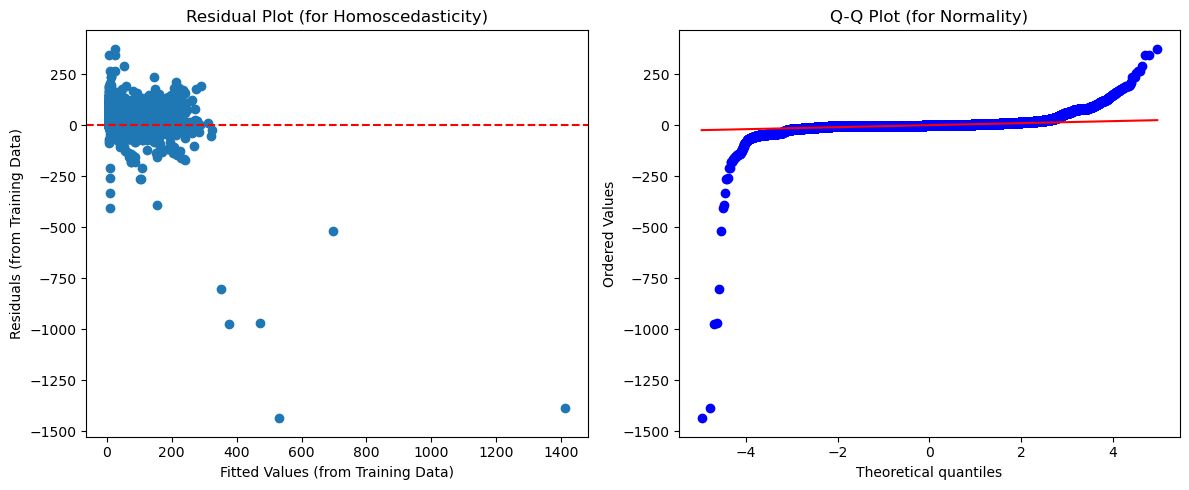

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                 6.016e+06
Date:                Thu, 13 Nov 2025   Prob (F-statistic):               0.00
Time:                        13:42:08   Log-Likelihood:            -6.4068e+06
No. Observations:             1956835   AIC:                         1.281e+07
Df Residuals:                 1956832   BIC:                         1.281e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             7.7147      0.006   1188.371      0.000       7.702       7.727
trip_distance     3.6846      0.001   3468.354      0.000       3.683       3.687
is_weekend       -0.7546      0.010    -75.961      0.000      -0.774      -0.735
==============================================================================
Omnibus:                  3594987.013   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     856925484198.870
Skew:                         -11.921   Prob(JB):                         0.00
Kurtosis:                    3244.816   Cond. No.                         12.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

MAE: 3.54 ———— RMSE: 38.19


In [57]:
# Model 1: Base
model1 = sm.OLS(y_train, x_train).fit()
pred1 = model1.predict(x_test)
mae1 = mean_absolute_error(y_test, pred1)
rmse1 = mean_squared_error(y_test, pred1)

train_residuals = model1.resid 

# Homoscedasticity
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(model1.fittedvalues, train_residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot (for Homoscedasticity)')
plt.xlabel('Fitted Values (from Training Data)')
plt.ylabel('Residuals (from Training Data)')

# Q-Q Plot
plt.subplot(1, 2, 2)
stats.probplot(train_residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot (for Normality)')

plt.tight_layout()
plt.show()

display(model1.summary())
print(f"MAE: {mae1:.2f} ———— RMSE: {rmse1:.2f}")

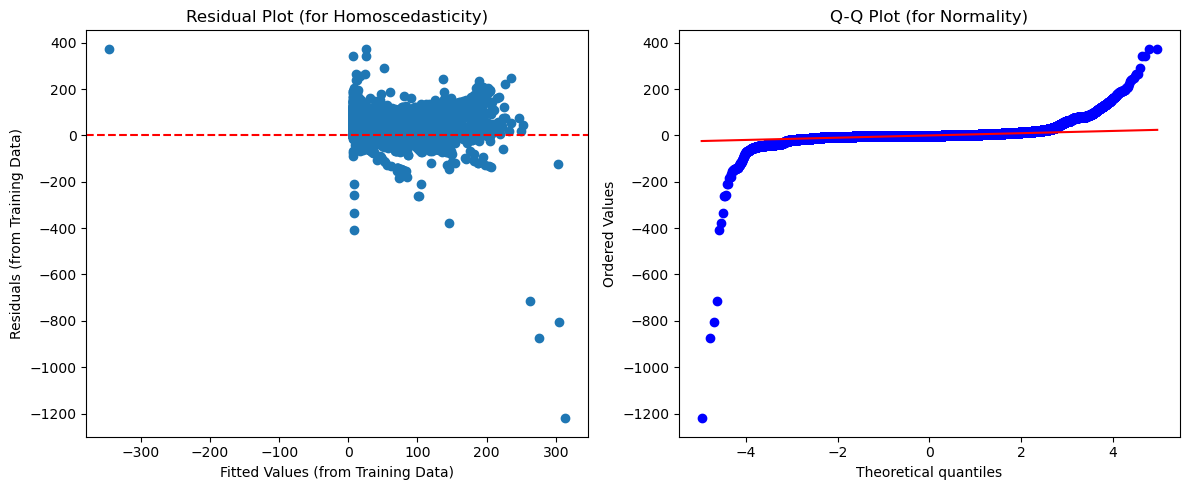

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                 3.184e+06
Date:                Thu, 13 Nov 2025   Prob (F-statistic):               0.00
Time:                        13:42:13   Log-Likelihood:            -6.3588e+06
No. Observations:             1956835   AIC:                         1.272e+07
Df Residuals:                 1956830   BIC:                         1.272e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     7.1743      0.007   1042.142      0.000       7.161       7.188
trip_distance             3.9623      0.001   2672.444      0.000       3.959       3.965
is_weekend               -0.6421      0.012    -52.495      0.000      -0.666      -0.618
weekend_trip_distance    -0.0347      0.002    -15.464      0.000      -0.039      -0.030
trip_distance_sq         -0.0127   4.09e-05   -311.035      0.000      -0.013      -0.013
==============================================================================
Omnibus:                  1686027.628   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     141138967723.666
Skew:                          -2.166   Prob(JB):                         0.00
Kurtosis:                    1318.678   Cond. No.                         421.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

MAE: 3.47 ———— RMSE: 37.82


In [58]:
# Model 2: Engineered
model2 = sm.OLS(y_train2, x_train2).fit()
pred2 = model2.predict(x_test2)
mae2 = mean_absolute_error(y_test2, pred2)
rmse2 = mean_squared_error(y_test2, pred2)

train_residuals2 = model2.resid 

# 1. Plot for Homoscedasticity
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(model2.fittedvalues, train_residuals2)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot (for Homoscedasticity)')
plt.xlabel('Fitted Values (from Training Data)')
plt.ylabel('Residuals (from Training Data)')

# 2. Q-Q Plot for Normality
plt.subplot(1, 2, 2)
stats.probplot(train_residuals2, dist="norm", plot=plt)
plt.title('Q-Q Plot (for Normality)')

plt.tight_layout()
plt.show()

display(model2.summary())
print(f"MAE: {mae2:.2f} ———— RMSE: {rmse2:.2f}")

(For myself) For binary variables, like is_weekend, we are simply only comparing weekdays (0) vs. (1)

### Step 7 — Interpret Key Coefficients (Plain Language)

Write **unit-based** interpretations for 2–3 impactful coefficients **in the Engineered model**, noting:
- The **baseline** category for dummies (the dropped category).
- **Interaction** meaning (change in slope under the condition).
- **Polynomial** meaning (curve: does effect rise then taper?).



***

### **Baseline**
**is_weekend**
- With a constant of 7.17, this is telling us that when is_weekend = 0 (thus signaling a weekend), that fare_amount is typically $7.17. 
- The slope is telling us that when it is a weekend, the fare falls down by roughly $0.64.

**trip_distance**
- Here, the constant does not signify anything. However, the slope tells us that fare amount increases $3.96 for every +1 mile.
- The high t score likely tells us that this variable is a significant factor in the variation of fare amount.

### **Interaction**
**weekend_trip_distance**
- For every +1 mile on a weekend, we see a decrease of $0.03 in the *effect* of whether the day is a weekend or not.
- However, the t score tells that this interaction term is not a really a factor at all for this variation of fare amount.

### **Polynomial**
**trip_distance_sq**
- As we are testing if fare amount changes exponentially as the trip distance increases, the coefficient tells us that there is a very slight negative curve. For the most part, it doesn't change exponentially.

<br>

***

*(Use this template; edit to your variables/units):*

- **Dummy (pay_…):** Compared to baseline **[dropped category]**, the expected **Y** is **β** higher/lower, holding other features constant.  
- **Interaction (dist×weekend):** On weekends, each additional **mile** changes **Y** by **β_interaction** *more/less* than on weekdays, holding other features constant.  
- **Polynomial (distance²):** The marginal effect of distance changes with distance; the negative/positive β on distance² indicates **diminishing/increasing** returns.

### Step 8 —  Quick Diagnostics (Train Residuals) — Engineered Model
- **Residuals vs Fitted:** random cloud ≈ good; cone/funnel suggests non-constant variance.  
- **Q–Q plot:** points roughly along diagonal (normality for inference).  
- **Durbin–Watson:** printed in `eng_model.summary()` (~2 suggests independence).

<br>
<div align='center'>

# **This step was included in step 6**
</div>

## We Share — Reflection & Wrap‑Up

**Notes on Feature Selection**
- If **Engineered** doesn’t beat **Base** on TEST (or gains are tiny), prefer **Base** for simplicity.  
- If two engineered features are redundant (e.g., highly correlated dummies), consider dropping one.  
- Keep features that improve TEST error **and** you can explain to a stakeholder.


Write **2 short paragraphs** and be specific:


1) **Which model would you deploy today—Base or Engineered—and why?**  
Use **TEST MAE/RMSE in units**, your coefficient interpretations (baseline/interaction/polynomial), and any residual observations.

2) **What engineered feature was most useful (or not)?**  
Explain the **business logic** behind it and whether it earned its place on the TEST set. If not, what would you try next (different interaction, different categorical, or simplifying features)?

I would want to push out the engineered model, with significant improvements to be made. I see the benefit in having interaction and polynomial terms, as they can give us additional insights in the relationship between 2+ variables. For example, doing trip_distance * is_weekend can help me find the actually effect of fare amount that trip distance has on weekends vs. weekdays. Furthermore, polynomial terms can help us determine if there is an exponential increase in the effect of 2+ variables.

While these terms did not benefit much from the model, I think another term could be something regarding the additional fees that may be added on. Dummy variables can be created for tolls, extra charges, etc., and those dummy variables can then be used to find their effect based on trip distance, duration, or many other combinations.

***

### **Below is just the code-along from the readings**

In [59]:
# First, recreate the DataFrame from Reading 9
np.random.seed(0)
ad_spend = np.random.rand(100) * 10
web_traffic = np.random.rand(100) * 50
sales = 15 + 5 * ad_spend + 1.5 * web_traffic + np.random.normal(0, 8, 100)
df_mlr = pd.DataFrame({'sales': sales, 'ad_spend': ad_spend, 'web_traffic': web_traffic})
df_mlr['day_type'] = np.random.choice(['Weekday', 'Weekend'], 100)

# --- 1. Interaction Term ---
df_mlr['ad_x_traffic'] = df_mlr['ad_spend'] * df_mlr['web_traffic']

# --- 2. Squared Term (for non-linear effect) ---
df_mlr['ad_spend_sq'] = df_mlr['ad_spend']**2

# --- 3. Dummy Variables (Method A: pandas.get_dummies) ---
# Easy for analysis, use drop_first=True
dummies_pd = pd.get_dummies(df_mlr['day_type'], drop_first=True, prefix='day')
df_with_pd = pd.concat([df_mlr, dummies_pd], axis=1)
print("--- Data with pd.get_dummies ---")
print(df_with_pd.head())

# --- 3. Dummy Variables (Method B: sklearn.OneHotEncoder) ---
# Better for ML pipelines. Note: This is more complex to set up.
# We fit the encoder on the 'day_type' column
ohe = OneHotEncoder(drop='first', sparse_output=False)
feature_array = ohe.fit_transform(df_mlr[['day_type']])
feature_labels = list(ohe.get_feature_names_out())
dummies_skl = pd.DataFrame(feature_array, columns=feature_labels)

# Concatenate back to the original dataframe
df_with_skl = pd.concat([df_mlr.reset_index(drop=True), dummies_skl.reset_index(drop=True)], axis=1)
print("\n--- Data with sklearn.OneHotEncoder ---")
print(df_with_skl.head())


--- Data with pd.get_dummies ---
     sales  ad_spend  web_traffic day_type  ad_x_traffic  ad_spend_sq  \
0 102.2900    5.4881      33.8908  Weekend      185.9974      30.1196   
1  62.3706    7.1519      13.5004  Weekday       96.5534      51.1496   
2  91.0980    6.0276      36.7597  Weekend      221.5740      36.3324   
3 110.9057    5.4488      48.1094  Weekend      262.1402      29.6898   
4  50.8550    4.2365      12.4377  Weekend       52.6927      17.9483   

   day_Weekend  
0         True  
1        False  
2         True  
3         True  
4         True  

--- Data with sklearn.OneHotEncoder ---
     sales  ad_spend  web_traffic day_type  ad_x_traffic  ad_spend_sq  \
0 102.2900    5.4881      33.8908  Weekend      185.9974      30.1196   
1  62.3706    7.1519      13.5004  Weekday       96.5534      51.1496   
2  91.0980    6.0276      36.7597  Weekend      221.5740      36.3324   
3 110.9057    5.4488      48.1094  Weekend      262.1402      29.6898   
4  50.8550    4.2365